# Описание проекта

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.
Идея решения задачи от заказчика: 
Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties) 
Для модели выбрать тип виновника — только машина (car).
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
Для моделирования ограничиться данными за 2012 год — они самые свежие.
Обязательное условие — учесть фактор возраста автомобиля.
На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы: 
Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 
Инструкция по выполнению проекта

**План выполнения проекта**

* Шаг 1. Загрузите таблицы sql
 
* Шаг 2. Проведите первичное исследование таблиц

* Шаг 3. Проведите статистический анализ факторов ДТП

* Шаг 4. Создайте модель для оценки водительского риска

* Шаг 5. Найдите лучшую модель

* Шаг 6. Проверьте лучшую модель в работе

* Шаг 7. Сделайте общий вывод по модели  

**Описание таблиц**

* collisions — общая информация о ДТП 
 Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда. 
* parties — информация об участниках ДТП 
 Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number. 
* vehicles — информация о пострадавших машинах 
 Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

 Подробное описание данных будет далее в проекте.

In [2]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import shap
    import time

    from catboost import CatBoostClassifier
    from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
    from sklearn.compose import ColumnTransformer
    from sklearn.dummy import DummyClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_recall_curve, average_precision_score
    from sklearn.model_selection import train_test_split, RandomizedSearchCV
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import OrdinalEncoder, RobustScaler, OneHotEncoder
    from sklearn.svm import LinearSVC
    from sqlalchemy import create_engine, text
    from ydata_profiling import ProfileReport
except:
    !pip install feature_engine
    !pip install pandas-profiling

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import shap
    import time

    from catboost import CatBoostClassifier
    from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
    from sklearn.compose import ColumnTransformer
    from sklearn.dummy import DummyClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_recall_curve, average_precision_score
    from sklearn.model_selection import train_test_split, RandomizedSearchCV
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import OrdinalEncoder, RobustScaler, OneHotEncoder
    from sklearn.svm import LinearSVC
    from sqlalchemy import create_engine, text
    from ydata_profiling import ProfileReport

In [3]:
random_state = 42

## Подключение к базе данных и загрузка таблиц sql

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)
del db_config
del connection_string

## Проведение первичного исследования таблиц

In [6]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE'
'''

pd.DataFrame(engine.connect().execute(text(query)))

,table_name
0,pg_type
1,pg_foreign_table
2,pg_amop
3,pg_amproc
4,pg_language
...,...
59,pg_inherits
60,collisions
61,case_ids
62,parties


In [7]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [8]:
query = '''
SELECT *
FROM case_ids
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [9]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [10]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


### Выводы
1. Все таблицы имеют данные для выполнения поставленных задач
2. Таблиц достаточно для выполнения поставленных задач
3. Все таблицы имеют общий ключ для связи между собой (case_id)

##  Проведение статистического анализа факторов ДТП

In [11]:
query = '''
SELECT extract(month from collision_date) as month, count(*)
FROM collisions
WHERE extract(year from collision_date) < 2012
GROUP BY month
ORDER BY month;
'''

collisions_per_month = pd.DataFrame(engine.connect().execute(text(query)))

In [12]:
collisions_per_month

,month,count
0,1,99880
1,2,98373
2,3,107036
3,4,101032
4,5,105148
5,6,99531
6,7,101835
7,8,103467
8,9,104649
9,10,111933


In [13]:
query = '''

SELECT EXTRACT(YEAR FROM collision_date)::int,
       COUNT(DISTINCT(EXTRACT(MONTH FROM collision_date)))
FROM collisions
GROUP BY EXTRACT(YEAR FROM collision_date)
''' 
vehicles = pd.read_sql_query(query, con = engine)
vehicles

,extract,count
0,2009,12
1,2010,12
2,2011,12
3,2012,12
4,2013,6
5,2020,2


Т.к. данные за 2013 и 2020 года неполные, не будем включать их в анализ.

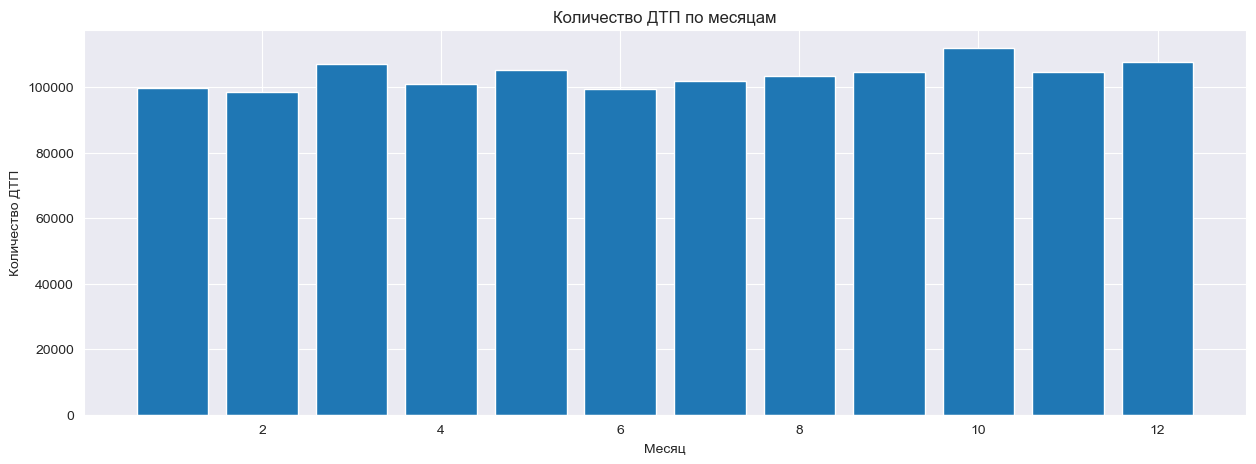

In [14]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
plt.bar(collisions_per_month['month'], collisions_per_month['count'])
plt.title('Количество ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.show()

### Количество ДТП по месяцам
* Конкретных зависимостей не наблюдается
* В октябре самое большое количество ДТП
* В феврале самое маленькое количество ДТП

### Список задач для статистического анализа
1) Выявить сезонность аварий.
План работы:
    - загрузить данные
    - построить график
    - сделать выводы 


2) Провести анализ возраста автопарка.
План работы:
    - загрузить данные
    - построить график
    - сделать выводы     


3) Провести анализ серьезности повреждений исходя из состояния дороги.
План работы:
    - загрузить данные
    - построить график
    - сделать выводы 


4) Оценить влияние возраста авто на серьезность повреждений.
План работы:
    - загрузить данные
    - построить график
    - сделать выводы 


5) Найти самые частые категории нарушений.
План работы:
    - загрузить данные
    - построить график
    - сделать выводы   


6) Оценить наличие громкой связи в зависимости от возраста авто.
План работы:
    - загрузить данные
    - построить график
    - сделать выводы   

    
7) Провести анализ серьезности повреждений исходя из состояния виновника.
План работы:
    - загрузить данные
    - построить график
    - сделать выводы  

### Сезонность аварий

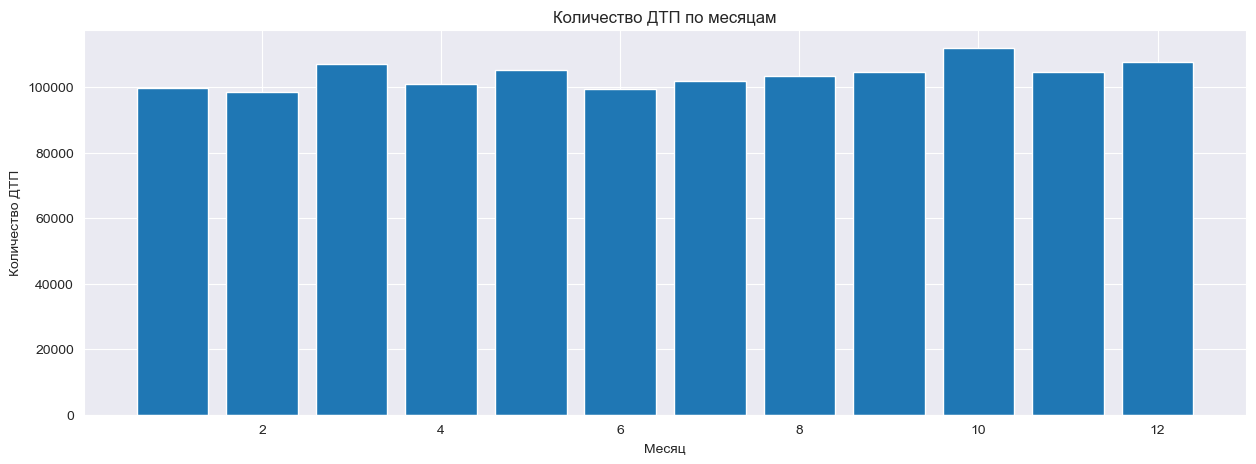

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
plt.bar(collisions_per_month['month'], collisions_per_month['count'])
plt.title('Количество ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.show()

### Анализ возраста автопарка.

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


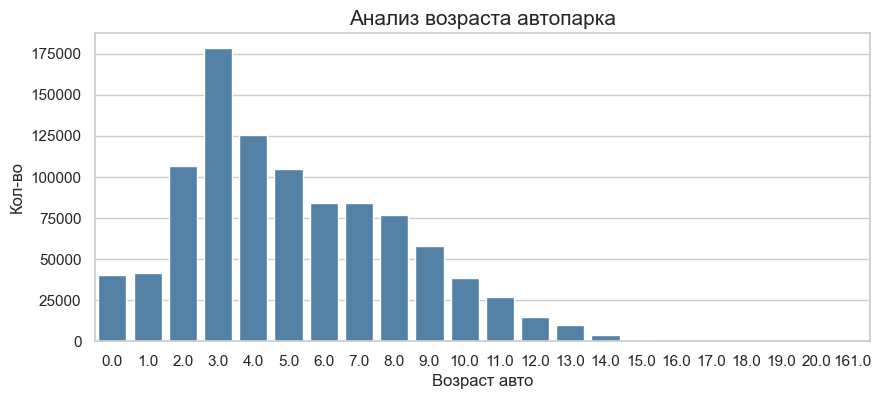

In [16]:
query = '''

SELECT vehicle_age
FROM vehicles 
''' 
vehicles = pd.read_sql_query(query, con = engine) 

sns.set(style="whitegrid")
plt.figure(figsize=(10, 4))
sns.countplot(x ='vehicle_age', data = vehicles, color ='steelblue')
plt.xlabel('Возраст авто', fontsize=12)
plt.ylabel('Кол-во', fontsize=12)
plt.title('Анализ возраста автопарка', fontsize=15)
plt.draw()

Большая часть автопарка имеет возраст от 2 до 9 лет.

### Анализ серьезности повреждений исходя из состояния дороги

In [17]:
query = '''

SELECT collision_damage,
       road_surface
FROM collisions 
''' 
vehicles = pd.read_sql_query(query, con = engine) 

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


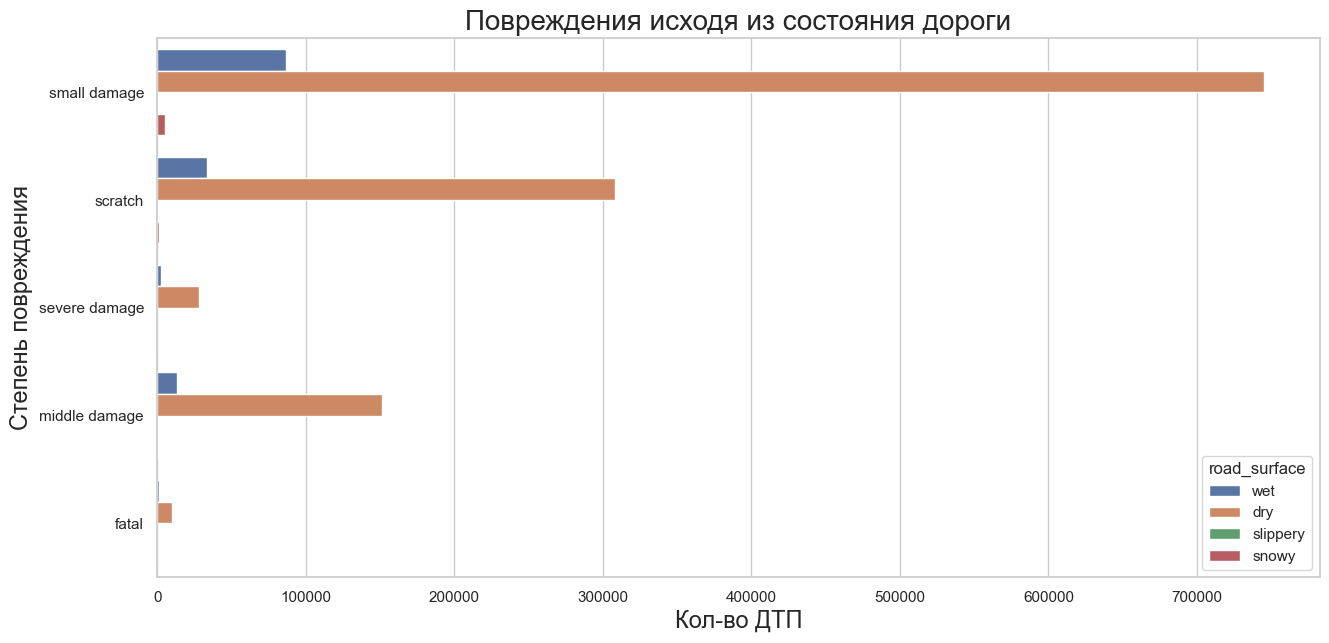

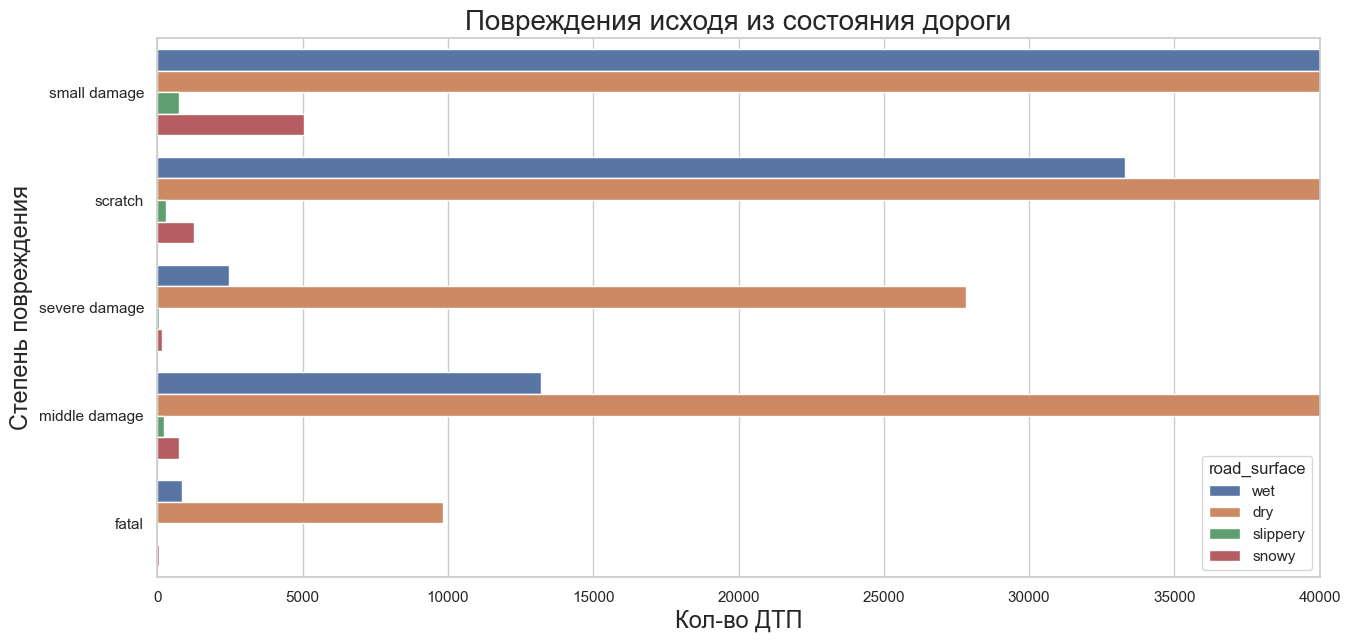

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 7))
sns.countplot(y ='collision_damage', data = vehicles, hue='road_surface')
plt.xlabel('Кол-во ДТП', fontsize=17)
plt.ylabel('Степень повреждения', fontsize=17)
plt.title('Повреждения исходя из состояния дороги', fontsize=20)
plt.draw()

sns.set(style="whitegrid")
plt.figure(figsize=(15, 7))
sns.countplot(y ='collision_damage', data = vehicles, hue='road_surface')
plt.xlabel('Кол-во ДТП', fontsize=17)
plt.ylabel('Степень повреждения', fontsize=17)
plt.title('Повреждения исходя из состояния дороги', fontsize=20)
plt.xlim([0, 40000])
plt.draw()

Для всех типов повреждений топ-3 состояния дороги выглядит следующим образом:

  - dry
  - wet
  - snowy

### Влияние возраста авто на серьезность повреждений.

In [19]:
query = '''

SELECT CASE 
           WHEN v.vehicle_age <= 2 THEN 'age <= 2'
           WHEN v.vehicle_age > 2 AND v.vehicle_age <= 5 THEN '2 < age <= 5'
           WHEN v.vehicle_age > 5 AND v.vehicle_age <= 8 THEN '5 < age <= 8'
           WHEN v.vehicle_age > 8 THEN 'age > 8'
       END AS age,
       c.collision_damage
FROM vehicles AS v
JOIN collisions AS c ON v.case_id = c.case_id
''' 
vehicles = pd.read_sql_query(query, con = engine) 

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


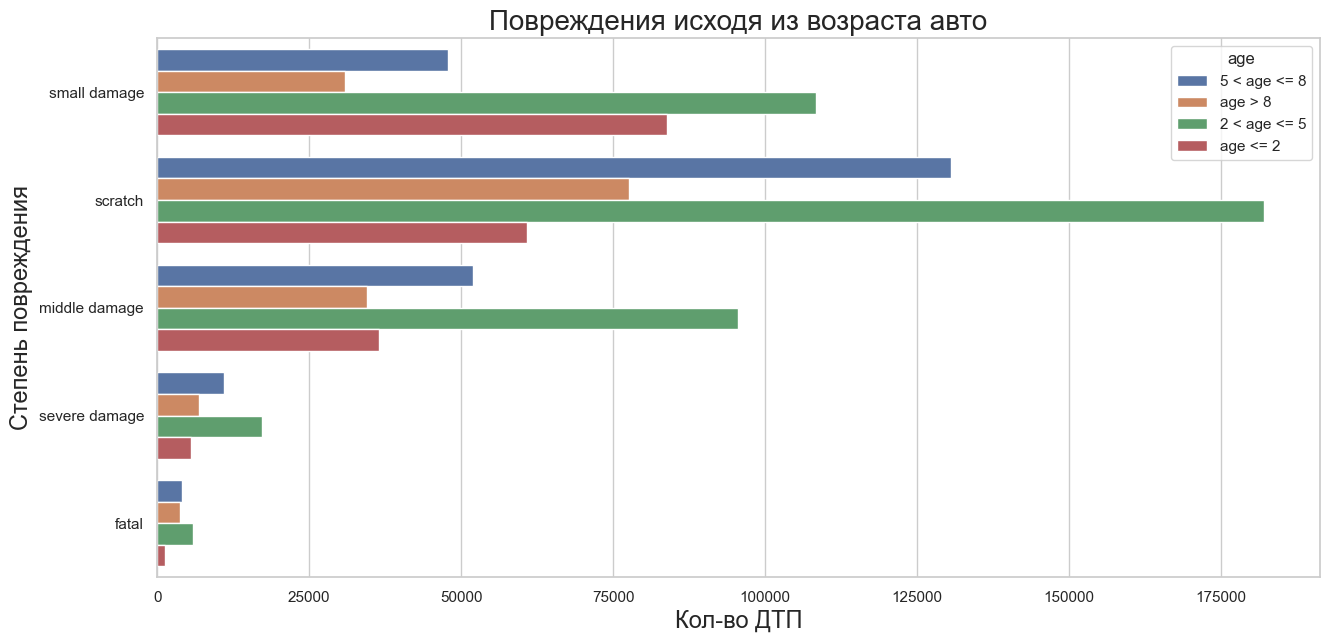

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 7))
sns.countplot(y ='collision_damage', data = vehicles, hue='age')
plt.xlabel('Кол-во ДТП', fontsize=17)
plt.ylabel('Степень повреждения', fontsize=17)
plt.title('Повреждения исходя из возраста авто', fontsize=20)
plt.draw()

Для фатального повреждения наблюдается снижение доли авто возрастом до 2 лет, тогда как для небольших повреждений - обратная ситуация.

### Категории нарушений

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


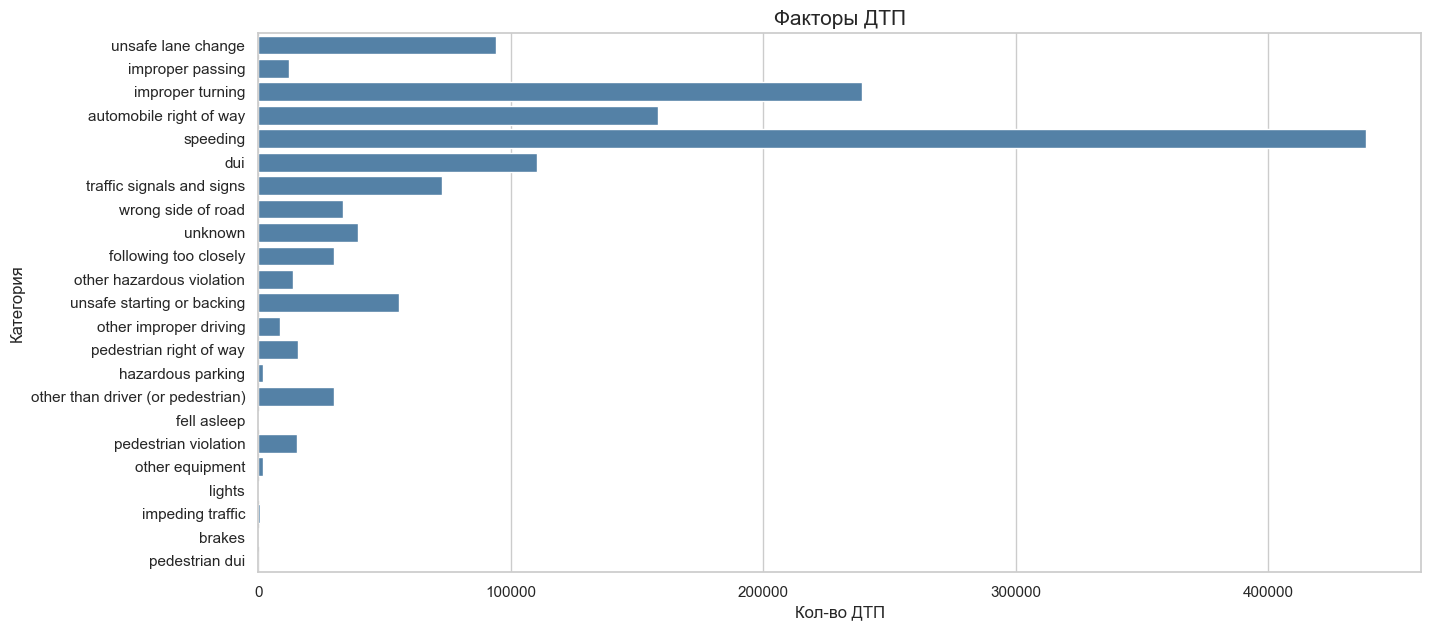

In [21]:
query = '''

SELECT pcf_violation_category
FROM collisions
''' 
vehicles = pd.read_sql_query(query, con = engine) 

sns.set(style="whitegrid")
plt.figure(figsize=(15, 7))
sns.countplot(y ='pcf_violation_category', data = vehicles, color ='steelblue')
plt.xlabel('Кол-во ДТП', fontsize=12)
plt.ylabel('Категория', fontsize=12)
plt.title('Факторы ДТП', fontsize=15)
plt.draw()

Топ 3 категорий нарушений:

- превышение скорости
- неправильный поворот
- автомобильное право проезда   

### Наличие громкой связи в зависимости от возраста авто

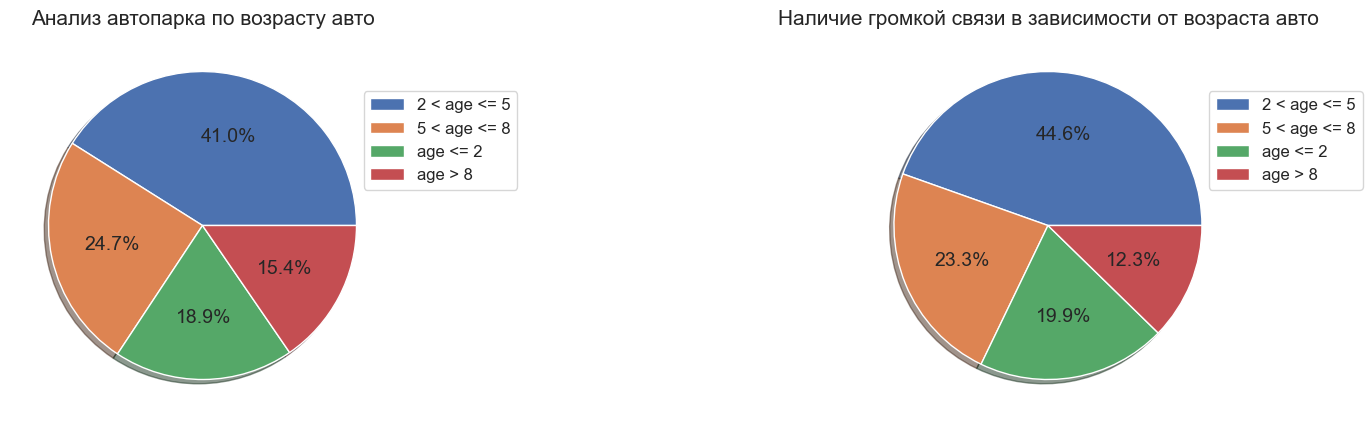

In [22]:
query = '''

SELECT CASE 
           WHEN v.vehicle_age <= 2 THEN 'age <= 2'
           WHEN v.vehicle_age > 2 AND v.vehicle_age <= 5 THEN '2 < age <= 5'
           WHEN v.vehicle_age > 5 AND v.vehicle_age <= 8 THEN '5 < age <= 8'
           WHEN v.vehicle_age > 8 THEN 'age > 8'
       END AS age,
       SUM(p.cellphone_in_use),
       COUNT(v.id)
FROM vehicles AS v
JOIN parties AS p ON v.case_id = p.case_id AND v.party_number = p.party_number
WHERE v.vehicle_age IS NOT Null
GROUP BY age
''' 
vehicles = pd.read_sql_query(query, con = engine) 
vehicles


fig, axes = plt.subplots(1, 2, figsize=(20,10))
explode = (0.05, 0) 

ax = vehicles['sum'].plot(kind='pie', fontsize=14, use_index=False, shadow=True, \
                      title='Наличие громкой связи в зависимости от возраста авто', figsize=(20,5),
                      ax=axes[1], autopct='%1.1f%%', labels=None)
ax.legend(vehicles['age'], bbox_to_anchor=(0.897,0.87), prop={'size':12})
ax.set_ylabel('')
ax.title.set_size(15) 

ax = vehicles['count'].plot(kind='pie', fontsize=14, use_index=False, shadow=True, \
                      title='Анализ автопарка по возрасту авто', figsize=(20,5),
                      ax=axes[0], autopct='%1.1f%%', labels=None)
ax.legend(vehicles['age'], bbox_to_anchor=(0.897,0.87), prop={'size':12})
ax.set_ylabel('')
ax.title.set_size(15);

Автопарк равномерно оборудован громкой связью.

### Анализ серьезности повреждений исходя из состояния виновника

In [23]:
query = '''

SELECT CASE 
           WHEN p.party_sobriety = 'had not been drinking' THEN 'не пил'
           WHEN p.party_sobriety = 'impairment unknown' OR p.party_sobriety = 'not applicable' THEN 'не известно'
           WHEN p.party_sobriety = 'had been drinking, under influence' 
             OR p.party_sobriety = 'had been drinking, impairment unknown' 
             OR p.party_sobriety = 'had been drinking, not under influence' THEN 'пил'
       END AS party_sobriety,
       c.collision_damage
FROM (
        SELECT *
        FROM parties 
        WHERE at_fault = 1
     ) AS p
JOIN collisions AS c ON p.case_id = c.case_id
''' 
vehicles = pd.read_sql_query(query, con = engine) 

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


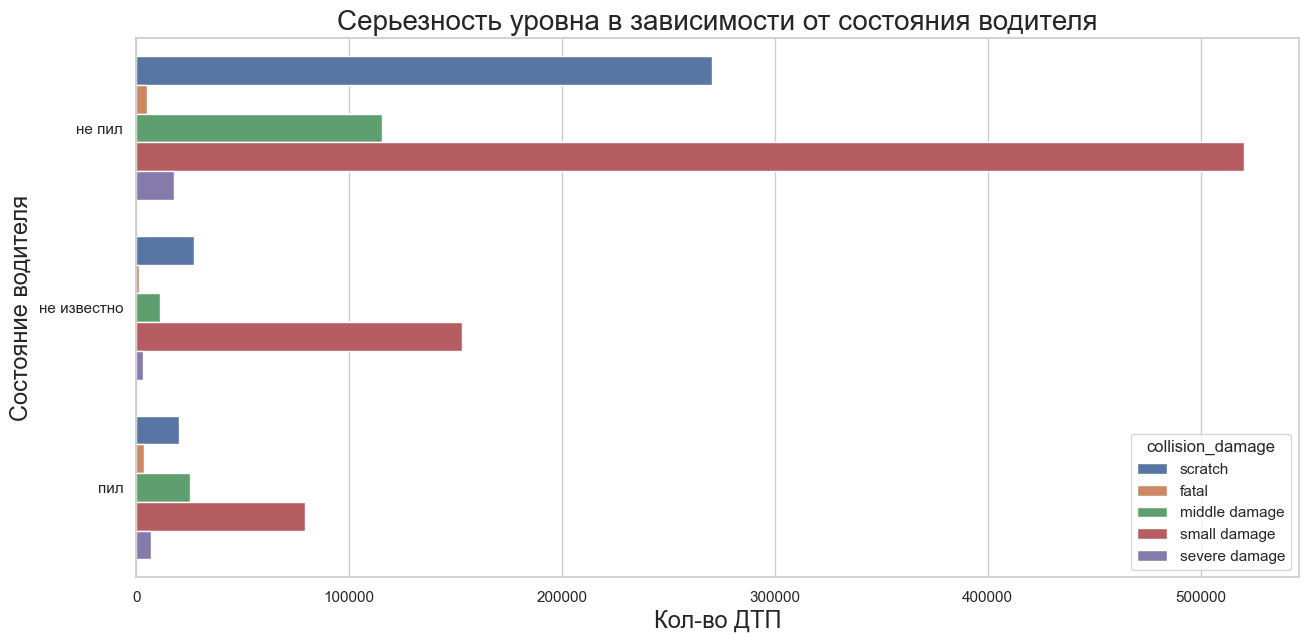

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 7))
sns.countplot(y ='party_sobriety', data = vehicles, hue='collision_damage')
plt.xlabel('Кол-во ДТП', fontsize=17)
plt.ylabel('Состояние водителя', fontsize=17)
plt.title('Серьезность уровна в зависимости от состояния водителя', fontsize=20)
plt.draw()

Для выпивших виновников ДТП повышается доля среднего урона авто. Большая часть фатального урона приходится на водителей которые не пили.

### Вывод

* Наибольшее кол-во аварий происходит в весенне-зимний период.

* Большая часть автопарка имеет возраст от 2 до 9 лет.

* Для всех типов повреждений топ-3 состояния дороги выглядит следующим образом:

    * dry
    * wet
    * snowy
* Для фатального повреждения наблюдается снижение доли авто возрастом до 2 лет, тогда как для небольших повреждений - обратная ситуация.

* Топ 3 категорий нарушений:

    * превышение скорости
    * неправильный поворот
    * автомобильное право проезда
* Автопарк равномерно оборудован громкой связью.

* Для выпивших виновников ДТП повышается доля среднего урона авто. Большая часть фатального урона приходится на водителей которые не пили.

## Создание модели для оценки водительского риска

### Собираем требуемые данные из баззы данных

In [25]:
query = '''

WITH collisions AS (SELECT *,
                           EXTRACT(MONTH FROM collision_date) AS collision_month
                    FROM collisions
                    WHERE case_id IN (SELECT DISTINCT case_id
                                      FROM parties
                                      WHERE at_fault = 1 AND party_type = 'car'
                                     )
                                  AND EXTRACT(YEAR FROM collision_date) = 2012
                                  AND collision_damage NOT LIKE 'scratch'
                    )
                    
SELECT *
FROM parties AS p
LEFT OUTER JOIN collisions AS c ON p.case_id = c.case_id
LEFT OUTER JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE c.county_city_location IS NOT NULL 
      AND v.id IS NOT NULL
''' 

df = pd.DataFrame(engine.connect().execute(text(query)))

### Подбираем данные для модели

In [26]:
df = df[['vehicle_type', # Тип кузова влияет на характеристики автомобиля тем самым и на возможность аварии, ее последстия и другое
         'vehicle_transmission', # Тип КПП влияет на воздействие человека на автомобиль тем самым и на возможность аварии
         'vehicle_age', # Возраст автомобиля влияет на его техническое состояние, что влияет на возможность аварии
         'county_city_location', # Разные города имеют разные дороги, что влияет на возможность аварии
         'distance', # Расстояние от главной дороги может влиять на качество дороги, что влияет на возможность аварии
         'direction', # Не известно как может направление движения влиять на возможность аварии, стоит проверить
         'intersection', # Сложный перекресток может влиять на принятие решения человеком
         'weather_1', # Погода создает определенные условия для вождения
         'location_type', # Тип дороги влияет на скорость движения и восприятия пути человеком
         'primary_collision_factor', # Неправильные действия при вождении увеличивают вероятность аварии
         'pcf_violation_category', # Неправильные действия при вождении увеличивают вероятность аварии
         'road_surface', # Дорожное покрытие влияет на поведение автомобиля
         'road_condition_1', # Состояние дороги влияет на поведение автомобиля
         'lighting', # Освещение влияет на видимость дороги и других автомобилей
         'collision_date',# Возьмем месяц аварии. Мы узнали, что в первой половине года аварий больше
         'collision_time', # Возьмем час аварии для упрощения признака
         'at_fault', # Целевая переменная
         'insurance_premium', # Стоимость страховки может влиять на качество вождения
         'party_sobriety', # Состояние водителя влияет на качество вождения
         'party_drug_physical', # Состояние водителя влияет на качество вождения
         'cellphone_in_use']] # Мобильное устройство может отвлекать водителя

### Формируем полную таблицу для модели и проводим анализ

### Предобработка признаков

In [27]:
cat_column = []
num_column = []

at_fault

In [28]:
df['at_fault'] = df['at_fault'].astype('bool')
cat_column.append('at_fault')

insurance_premium

In [29]:
df['insurance_premium'] = df['insurance_premium'].fillna(0)
num_column.append('insurance_premium')

party_sobriety

In [30]:
df['party_sobriety'] = df['party_sobriety'].fillna('had not been drinking')
cat_column.append('party_sobriety')

party_drug_physical

In [31]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('no drugs')
cat_column.append('party_drug_physical')

cellphone_in_use

In [32]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0)
df['cellphone_in_use'] = df['cellphone_in_use'].astype('bool')
cat_column.append('cellphone_in_use')

vehicle_type

In [33]:
df['vehicle_type'] = df['vehicle_type'].fillna('not applicable')
cat_column.append('vehicle_type')

vehicle_transmission

In [34]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('not applicable')
cat_column.append('vehicle_transmission')

vehicle_age

In [35]:
df.vehicle_age.value_counts(ascending=True)

vehicle_age
19.0         1
161.0        2
17.0         3
16.0         7
15.0        41
14.0       284
13.0       558
12.0       863
11.0      1360
10.0      1945
1.0       2440
9.0       2779
0.0       2988
8.0       3500
7.0       3826
6.0       3927
5.0       5461
2.0       6082
4.0       7077
3.0      10883
Name: count, dtype: int64

In [36]:
# Заполним пропуски в возрасте автомобиля самым частым значением
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].mode()[0])
df = df[df['vehicle_age'] != 161.0]
num_column.append('vehicle_age')

Удалим автомобили, которые возрастом 161 год

county_city_location

In [37]:
num_column.append('county_city_location')

distance

In [38]:
df = df[df['distance'] <= 20_000]
num_column.append('distance')

Ограничимся дестанцией в 20 км.

direction

In [39]:
df['direction'] = df['direction'].fillna('unknown')
cat_column.append('direction')

intersection

In [40]:
df['intersection'] = df['intersection'].fillna(0)
df['intersection'] = df['intersection'].astype('bool')
cat_column.append('intersection')

weather_1

In [41]:
df['weather_1'] = df['weather_1'].fillna('unknown')
cat_column.append('weather_1')

location_type

In [42]:
df['location_type'] = df['location_type'].fillna('road')
cat_column.append('location_type')

primary_collision_factor

In [43]:
cat_column.append('primary_collision_factor')

pcf_violation_category

In [44]:
df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown')
cat_column.append('pcf_violation_category')

road_surface

In [45]:
df['road_surface'] = df['road_surface'].fillna('dry')
cat_column.append('road_surface')

road_condition_1

In [46]:
df['road_condition_1'] = df['road_condition_1'].fillna('normal')
cat_column.append('road_condition_1')

lighting

In [47]:
df['lighting'] = df['lighting'].fillna('daylight')
cat_column.append('lighting')

collision_date

In [48]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
df['month'] = df['collision_date'].dt.month
df.drop('collision_date', axis=1, inplace=True)
cat_column.append('month')

collision_time

In [49]:
df['collision_time'] = df['collision_time'].fillna('00')
df['collision_time'] = df['collision_time'].apply(lambda x: str(x)[:2]).astype(int)
df['collision_time'] = df['collision_time'].astype('int')
cat_column.append('collision_time')

In [50]:
len(num_column), len(cat_column)

(4, 17)

In [51]:
df

,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,distance,direction,intersection,weather_1,location_type,primary_collision_factor,...,road_surface,road_condition_1,lighting,collision_time,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,month
0,sedan,manual,3.0,1000,20.0,east,False,clear,intersection,vehicle code violation,...,dry,normal,daylight,15,False,20.0,had not been drinking,no drugs,False,1
1,sedan,manual,6.0,1964,100.0,south,False,clear,highway,vehicle code violation,...,dry,construction,dark with street lights,1,False,33.0,"had been drinking, under influence",no drugs,False,2
2,sedan,auto,2.0,3711,0.0,unknown,True,clear,road,vehicle code violation,...,dry,normal,daylight,14,False,64.0,had not been drinking,no drugs,False,1
3,sedan,auto,2.0,1920,150.0,east,False,clear,road,vehicle code violation,...,dry,normal,dusk or dawn,17,False,32.0,had not been drinking,no drugs,False,1
4,coupe,manual,2.0,3900,500.0,south,False,clear,highway,vehicle code violation,...,dry,normal,dusk or dawn,17,True,18.0,impairment unknown,G,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55611,sedan,manual,2.0,3700,38.0,east,False,clear,road,vehicle code violation,...,dry,normal,daylight,7,False,53.0,had not been drinking,no drugs,False,4
55612,coupe,manual,3.0,1955,132.0,south,False,clear,road,vehicle code violation,...,dry,normal,daylight,12,True,18.0,"had been drinking, not under influence",no drugs,False,3
55613,sedan,manual,2.0,0791,7235.0,south,False,clear,highway,vehicle code violation,...,dry,normal,daylight,7,True,21.0,had not been drinking,no drugs,False,5
55614,sedan,manual,3.0,1942,300.0,south,False,raining,highway,vehicle code violation,...,wet,normal,daylight,12,True,29.0,had not been drinking,no drugs,False,3


### Анализ данных

In [52]:
try:
    profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
    
    profile.to_file('car_accidents_analysis.html')
except:
    print('Ошибка сохранения файла')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categ

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
try:
    df.to_csv('df.csv', index=False)
except:
    print('Ошибка сохранения файла')

### Выводы по анализу данных
1. at_fault имеет почти равное количество значений 0 и 1, что добавит точности при обучении модели
2. insurance_premium имеет правильное распределение с некоторыми скачками, возможно, это связано с маркетинговой деятельностью и прайс-листом. Все пропуски в данных были заполнены нулями, так как предположительно данные средства были не застрахованы.
3. party_sobriety и party_drug_physical имеют похожие распределения и в 80% данных зафиксированно отсутствие алкогольного, наркатического опьянения и других воздействий. Пропуски в данных заполнили отсутствием воздействий. Корреляция, также, похожа.
4. cellphone_in_use имеет в 99% случаев отрицательное значение.
5. vehicle_type, vehicle_transmission, vehicle_age основная масса данных была не зафиксированна так как не все участники аварии явлаются транспортным средством.
6. county_city_location вифим, что есть некоторые города, в которых аварий сильно больше чем в других.
7. distance четверь данных является пропущенными, что может быть связанно с тем, что авария произошла на основной дороге.
8. direction количество значений примерно похоже, но на дорогах с севера на юг аварий больше. Также, есть не зафиксированные данные, их около 20%.
9. intersection 80% аварий происходит не на перекрестке.
10. weather_1 основная масса аварий происходит в безоблачную погоду. Такая погода является распространенной в Калифорнии.
11. location_type основная масса данных пропущена и была заполнена значением 'road'.
12. primary_collision_factor 99% данных говорат о нарушении правил. Данные имеют очень высокую корреляцию и являются сильно не сбалансированными.
13. pcf_violation_category имеет нормальное распределение с сильным приобладанием нарушения правил скоростного режима.
15. road_surface 95% данных говорят о сухой дороге. Признак имеет высокую корреляцию и является сильно не сбалансированным.
16. road_condition_1 99% говорят о нормальной дороге.
17. lighting имеет нормальное распределение с сильным приобладанием дневного света.
18. collision_time нормальное распределение с двумя вершинами в 7-8 часов и 15-17 часов. Похоже на интервалы поездок на работу.
19. month в нашем наборе данных основная часть информации об аварих в первую половину года.

### Подготовка датасета к обучению модели

In [54]:
try:
    print('df is ready', df.shape)
except:
    df = pd.read_csv('df.csv')
    print('df is downloaded and ready', df.shape)

df is ready (55424, 21)


In [55]:
df.drop_duplicates(inplace=True)

In [56]:
train = df.drop('at_fault', axis=1)
target = df['at_fault'].astype('int')

In [57]:
cat_cols = train.select_dtypes(exclude='number').columns.tolist()
num_cols = train.select_dtypes(include='number').columns.tolist()

In [58]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=random_state)

### Создание пайплана и обучение моделей

Задача стоит в разработке системы прогнозирования виновника аварии. Наша основная цель - минимизировать шанс аварии с виновником арендующим транспортное средство компании. Если мы можем предсказать аварию заблаговременно, это поможет нам сократить издержки.

В контексте нашего вопроса, recall может быть наиболее важной метрикой, так как нам важно идентифицировать и предотвратить аварии (истинно положительные случаи), а неправильно ее предсказать не так страшно (ложно положительные случаи).

После проведенных тестов, стало ясно что Recall, дает неподходящий результат из-за переобучения. Будем брать F1 меру.

In [59]:
num_pipeline = Pipeline(steps=[
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

lin_cat_pipeline = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

lin_col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', lin_cat_pipeline, cat_cols)
], remainder='passthrough')

In [60]:
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', CatBoostClassifier(random_seed=random_state))
])

params = {
    'model__depth': [4, 5, 6, 7, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.075, 0.1, 0.15, 0.2],
    'model__l2_leaf_reg': [1, 2, 3, 4, 5, 7],
    'model__iterations': [100, 150, 200, 250, 300, 500],
    'model__border_count': [5, 10, 20, 30, 40],
    'model__thread_count': [2, 4, 6],
    'model__early_stopping_rounds': [10],
    'model__random_strength': [0.01, 0.1, 1, 1.5, 2],
    'model__max_ctr_complexity': [1, 2, 3, 4, 5]
}

cbc_grid = RandomizedSearchCV(pipeline,
                          params,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=random_state,
                          scoring='f1',
                          n_jobs=-1)

start = time.time()
cbc_grid.fit(X_train, y_train)
end = time.time()
cbc_time = end - start

print("Best Parameters:", cbc_grid.best_params_)
print("Best F1 Score:", cbc_grid.best_score_)
print("Time:", cbc_time)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.6895986	total: 69.1ms	remaining: 17.2s
0:	learn: 0.6900043	total: 70.2ms	remaining: 17.5s
0:	learn: 0.6899703	total: 70.9ms	remaining: 17.7s
0:	learn: 0.6679274	total: 73ms	remaining: 7.23s
1:	learn: 0.6862321	total: 78.6ms	remaining: 9.75s
1:	learn: 0.6867673	total: 79.6ms	remaining: 9.87s
1:	learn: 0.6464405	total: 81.3ms	remaining: 3.98s
1:	learn: 0.6867451	total: 82.3ms	remaining: 10.2s
2:	learn: 0.6836091	total: 95.2ms	remaining: 7.84s
2:	learn: 0.6836931	total: 101ms	remaining: 8.31s
2:	learn: 0.6309834	total: 102ms	remaining: 3.29s
3:	learn: 0.6810206	total: 103ms	remaining: 6.35s
3:	learn: 0.6805904	total: 108ms	remaining: 6.65s
2:	learn: 0.6829830	total: 109ms	remaining: 9.01s
3:	learn: 0.6194121	total: 113ms	remaining: 2.7s
4:	learn: 0.6776862	total: 114ms	remaining: 5.59s
4:	learn: 0.6781262	total: 118ms	remaining: 5.77s
4:	learn: 0.6078785	total: 120ms	remaining: 2.28s
5:	learn: 0.6751531	total: 121ms

In [61]:
pipeline = Pipeline(steps=[
    ('col_trans', lin_col_trans),
    ('model', LogisticRegression(tol=0.01, random_state=random_state))
])

param_dist = {
    'model__C': np.logspace(-3, 3, 7),
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

lr_grid = RandomizedSearchCV(pipeline,
                          param_dist,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=random_state,
                          scoring='f1',
                          n_jobs=-1)

start = time.time()
lr_grid.fit(X_train, y_train)
end = time.time()
lr_time = end - start

print("Best Parameters:", lr_grid.best_params_)
print("Best F1 Score:", lr_grid.best_score_)
print("Time:", lr_time)

The total space of parameters 28 is smaller than n_iter=50. Running 28 iterations. For exhaustive searches, use GridSearchCV.
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting 3 folds for each of 28 candidates, totalling 84 fits


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignor

[CV 1/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.481 total time=   0.3s
[CV 2/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.483 total time=   0.3s
[CV 3/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.487 total time=   0.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders

[CV 1/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.614 total time=   0.3s
[CV 2/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.615 total time=   0.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.609 total time=   0.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END model__C=0.001, model__penalty=l1, model__solver=saga;, score=0.501 total time=   1.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END model__C=0.001, model__penalty=l1, model__solver=saga;, score=0.503 total time=   1.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END model__C=0.001, model__penalty=l1, model__solver=saga;, score=0.507 total time=   1.1s
[CV 1/3] END model__C=0.001, model__penalty=l2, model__solver=saga;, score=0.616 total time=   1.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignor

[CV 1/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.624 total time=   0.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.623 total time=   0.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.618 total time=   0.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default valu

[CV 3/3] END model__C=0.001, model__penalty=l2, model__solver=saga;, score=0.612 total time=   1.1s
[CV 1/3] END model__C=0.01, model__penalty=l2, model__solver=liblinear;, score=0.648 total time=   0.4s
[CV 2/3] END model__C=0.001, model__penalty=l2, model__solver=saga;, score=0.618 total time=   1.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/li

[CV 2/3] END model__C=0.01, model__penalty=l2, model__solver=liblinear;, score=0.644 total time=   0.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and 

[CV 3/3] END model__C=0.01, model__penalty=l2, model__solver=liblinear;, score=0.637 total time=   0.5s
[CV 2/3] END model__C=0.1, model__penalty=l1, model__solver=liblinear;, score=0.660 total time=   0.4s
[CV 3/3] END model__C=0.1, model__penalty=l1, model__solver=liblinear;, score=0.650 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. The

[CV 1/3] END model__C=0.01, model__penalty=l1, model__solver=saga;, score=0.629 total time=   2.6s
[CV 1/3] END model__C=0.1, model__penalty=l1, model__solver=liblinear;, score=0.659 total time=   0.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/p

[CV 2/3] END model__C=0.01, model__penalty=l2, model__solver=saga;, score=0.642 total time=   1.8s
[CV 1/3] END model__C=0.01, model__penalty=l2, model__solver=saga;, score=0.648 total time=   1.9s
[CV 1/3] END model__C=0.1, model__penalty=l2, model__solver=liblinear;, score=0.659 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__penalty=l2, model__solver=liblinear;, score=0.656 total time=   0.4s
[CV 3/3] END model__C=0.1, model__penalty=l2, model__solver=liblinear;, score=0.655 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all 

[CV 2/3] END model__C=0.01, model__penalty=l1, model__solver=saga;, score=0.627 total time=   2.8s
[CV 3/3] END model__C=0.01, model__penalty=l1, model__solver=saga;, score=0.620 total time=   2.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all 

[CV 3/3] END model__C=0.01, model__penalty=l2, model__solver=saga;, score=0.637 total time=   2.0s
[CV 2/3] END model__C=1.0, model__penalty=l1, model__solver=liblinear;, score=0.660 total time=   0.4s
[CV 3/3] END model__C=1.0, model__penalty=l1, model__solver=liblinear;, score=0.660 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zer

[CV 1/3] END model__C=1.0, model__penalty=l1, model__solver=liblinear;, score=0.662 total time=   1.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__penalty=l2, model__solver=liblinear;, score=0.663 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__penalty=l2, model__solver=liblinear;, score=0.660 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__penalty=l2, model__solver=liblinear;, score=0.661 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__penalty=l2, model__solver=saga;, score=0.654 total time=   3.3s
[CV 1/3] END model__C=0.1, model__penalty=l2, model__solver=saga;, score=0.657 total time=   3.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zer

[CV 3/3] END model__C=0.1, model__penalty=l2, model__solver=saga;, score=0.651 total time=   3.5s
[CV 1/3] END model__C=0.1, model__penalty=l1, model__solver=saga;, score=0.655 total time=   5.1s
[CV 2/3] END model__C=0.1, model__penalty=l1, model__solver=saga;, score=0.656 total time=   5.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all 

[CV 1/3] END model__C=10.0, model__penalty=l1, model__solver=liblinear;, score=0.662 total time=   0.6s
[CV 3/3] END model__C=0.1, model__penalty=l1, model__solver=saga;, score=0.646 total time=   5.3s
[CV 2/3] END model__C=10.0, model__penalty=l1, model__solver=liblinear;, score=0.658 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/3] END model__C=10.0, model__penalty=l1, model__solver=liblinear;, score=0.659 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/3] END model__C=10.0, model__penalty=l2, model__solver=liblinear;, score=0.661 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/3] END model__C=10.0, model__penalty=l2, model__solver=liblinear;, score=0.660 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/3] END model__C=10.0, model__penalty=l2, model__solver=liblinear;, score=0.659 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__penalty=l2, model__solver=saga;, score=0.659 total time=   4.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__penalty=l2, model__solver=saga;, score=0.655 total time=   4.3s
[CV 3/3] END model__C=1.0, model__penalty=l2, model__solver=saga;, score=0.654 total time=   4.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zer

[CV 1/3] END model__C=100.0, model__penalty=l1, model__solver=liblinear;, score=0.661 total time=   0.5s
[CV 1/3] END model__C=1.0, model__penalty=l1, model__solver=saga;, score=0.660 total time=   7.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END model__C=1.0, model__penalty=l1, model__solver=saga;, score=0.654 total time=   7.4s
[CV 2/3] END model__C=1.0, model__penalty=l1, model__solver=saga;, score=0.656 total time=   7.7s
[CV 2/3] END model__C=100.0, model__penalty=l1, model__solver=liblinear;, score=0.658 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignor

[CV 3/3] END model__C=100.0, model__penalty=l1, model__solver=liblinear;, score=0.658 total time=   0.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/3] END model__C=10.0, model__penalty=l2, model__solver=saga;, score=0.659 total time=   4.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__penalty=l2, model__solver=liblinear;, score=0.662 total time=   0.5s
[CV 2/3] END model__C=100.0, model__penalty=l2, model__solver=liblinear;, score=0.659 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END model__C=100.0, model__penalty=l2, model__solver=liblinear;, score=0.662 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default valu

[CV 3/3] END model__C=10.0, model__penalty=l1, model__solver=saga;, score=0.656 total time=   7.0s
[CV 1/3] END model__C=10.0, model__penalty=l1, model__solver=saga;, score=0.659 total time=   7.3s
[CV 2/3] END model__C=10.0, model__penalty=l2, model__solver=saga;, score=0.656 total time=   4.4s
[CV 2/3] END model__C=10.0, model__penalty=l1, model__solver=saga;, score=0.656 total time=   7.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignor

[CV 3/3] END model__C=10.0, model__penalty=l2, model__solver=saga;, score=0.656 total time=   4.3s
[CV 1/3] END model__C=1000.0, model__penalty=l1, model__solver=liblinear;, score=0.661 total time=   0.5s
[CV 2/3] END model__C=1000.0, model__penalty=l1, model__solver=liblinear;, score=0.658 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. The

[CV 3/3] END model__C=1000.0, model__penalty=l1, model__solver=liblinear;, score=0.658 total time=   0.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__penalty=l2, model__solver=liblinear;, score=0.662 total time=   0.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__penalty=l2, model__solver=liblinear;, score=0.659 total time=   0.6s
[CV 1/3] END model__C=100.0, model__penalty=l2, model__solver=saga;, score=0.659 total time=   4.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its defaul

[CV 2/3] END model__C=100.0, model__penalty=l2, model__solver=saga;, score=0.656 total time=   4.1s
[CV 2/3] END model__C=100.0, model__penalty=l1, model__solver=saga;, score=0.656 total time=   6.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END model__C=100.0, model__penalty=l1, model__solver=saga;, score=0.660 total time=   6.9s
[CV 3/3] END model__C=100.0, model__penalty=l1, model__solver=saga;, score=0.656 total time=   6.5s
[CV 3/3] END model__C=100.0, model__penalty=l2, model__solver=saga;, score=0.656 total time=   4.2s
[CV 3/3] END model__C=1000.0, model__penalty=l2, model__solver=liblinear;, score=0.661 total time=   0.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__penalty=l1, model__solver=saga;, score=0.660 total time=   5.6s
[CV 2/3] END model__C=1000.0, model__penalty=l1, model__solver=saga;, score=0.656 total time=   5.5s
[CV 3/3] END model__C=1000.0, model__penalty=l1, model__solver=saga;, score=0.656 total time=   5.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__penalty=l2, model__solver=saga;, score=0.660 total time=   3.7s
[CV 2/3] END model__C=1000.0, model__penalty=l2, model__solver=saga;, score=0.656 total time=   3.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[CV 3/3] END model__C=1000.0, model__penalty=l2, model__solver=saga;, score=0.656 total time=   3.7s
Best Parameters: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 100.0}
Best F1 Score: 0.6611268622020683
Time: 25.909903049468994


In [62]:
pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', RandomForestClassifier(random_state=random_state))
])

param_dist = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15, 20]
}

rfc_grid = RandomizedSearchCV(pipeline,
                    param_dist,
                    n_iter=30,
                    cv=5,
                    verbose=5,
                    random_state=random_state,
                    scoring='f1',
                    n_jobs=-1)

start = time.time()
rfc_grid.fit(X_train, y_train)
end = time.time()
rfc_time = end - start

print("Best Parameters:", rfc_grid.best_params_)
print("Best F1 Score:", rfc_grid.best_score_)
print("Time:", rfc_time)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


The total space of parameters 25 is smaller than n_iter=30. Running 25 iterations. For exhaustive searches, use GridSearchCV.


[CV 4/5] END model__max_depth=None, model__n_estimators=100;, score=0.687 total time=   4.1s
[CV 5/5] END model__max_depth=None, model__n_estimators=100;, score=0.663 total time=   4.1s
[CV 2/5] END model__max_depth=None, model__n_estimators=100;, score=0.674 total time=   5.0s
[CV 1/5] END model__max_depth=None, model__n_estimators=100;, score=0.690 total time=   5.2s
[CV 3/5] END model__max_depth=None, model__n_estimators=100;, score=0.683 total time=   5.6s
[CV 2/5] END model__max_depth=None, model__n_estimators=200;, score=0.674 total time=   7.9s
[CV 3/5] END model__max_depth=None, model__n_estimators=200;, score=0.686 total time=   8.2s
[CV 5/5] END model__max_depth=None, model__n_estimators=200;, score=0.668 total time=   8.2s
[CV 1/5] END model__max_depth=None, model__n_estimators=200;, score=0.689 total time=  11.3s
[CV 4/5] END model__max_depth=None, model__n_estimators=200;, score=0.687 total time=  11.4s
[CV 1/5] END model__max_depth=None, model__n_estimators=300;, score=0.

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV 4/5] END model__max_depth=None, model__n_estimators=300;, score=0.689 total time=  15.3s
[CV 3/5] END model__max_depth=None, model__n_estimators=300;, score=0.682 total time=  15.5s
[CV 5/5] END model__max_depth=None, model__n_estimators=300;, score=0.668 total time=  15.0s
[CV 1/5] END model__max_depth=None, model__n_estimators=400;, score=0.687 total time=  15.5s
[CV 2/5] END model__max_depth=None, model__n_estimators=400;, score=0.678 total time=  15.7s
[CV 3/5] END model__max_depth=None, model__n_estimators=400;, score=0.684 total time=  15.7s
[CV 1/5] END model__max_depth=5, model__n_estimators=100;, score=0.666 total time=   1.4s
[CV 2/5] END model__max_depth=5, model__n_estimators=100;, score=0.656 total time=   1.3s
[CV 3/5] END model__max_depth=5, model__n_estimators=100;, score=0.670 total time=   1.3s
[CV 4/5] END model__max_depth=5, model__n_estimators=100;, score=0.667 total time=   1.4s
[CV 5/5] END model__max_depth=5, model__n_estimators=100;, score=0.655 total time=

In [63]:
pipeline = Pipeline(steps=[
    ('col_trans', lin_col_trans),
    ('model', LinearSVC(random_state=random_state))
])

param_dist = {
    'model__C': np.logspace(-3, 3, 7),
    'model__loss': ['hinge', 'squared_hinge'],
    'model__max_iter': np.arange(100, 1000, 100)
}

svc_grid = RandomizedSearchCV(pipeline,
                          param_dist,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=random_state,
                          scoring='f1',
                          n_jobs=-1)

start = time.time()
svc_grid.fit(X_train, y_train)
end = time.time()
svc_time = end - start

print("Best Parameters:", svc_grid.best_params_)
print("Best F1 Score:", svc_grid.best_score_)
print("Time:", svc_time)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output

[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.619 total time=   0.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `spar

[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.612 total time=   1.1s
[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.608 total time=   1.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories

[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.555 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda

[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.556 total time=   0.5s
[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.551 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.660 total time=   2.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These 

[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.658 total time=   3.1s
[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.695 total time=   2.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.1

[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.403 total time=   2.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.p

[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.663 total time=   3.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.655 total time=   3.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1

[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.591 total time=   3.7s
[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.584 total time=   3.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default v

[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.657 total time=   2.0s
[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.655 total time=   1.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.597 total time=   0.9s
[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.580 total time=   6.7s
[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.653 total time=   2.8s
[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.600 total time=   7.0s
[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.691 total time=   0.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib

[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.578 total time=   3.7s
[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.662 total time=   7.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.628 total time=   0.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessi

[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.573 total time=   0.9s
[CV 1/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.544 total time=   0.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.546 total time=   0.5s
[CV 3/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.542 total time=   0.4s
[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.578 total time=   1.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: Futu

[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.584 total time=   1.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse`

[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.578 total time=   0.6s
[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.572 total time=   0.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classe

[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.583 total time=   0.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.661 total time=   6.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/

[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.657 total time=   5.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.572 total time=   3.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.556 total time=   0.4s
[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.658 total time=   7.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its

[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.555 total time=   0.4s
[CV 1/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.647 total time=   5.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change fr

[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.551 total time=   0.6s
[CV 2/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.576 total time=   5.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib

[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.584 total time=   3.3s
[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.563 total time=   4.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessi

[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.663 total time=   5.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.577 total time=   3.6s
[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.639 total time=   0.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessi

[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.643 total time=   0.8s
[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.585 total time=   4.8s
[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.634 total time=   0.6s
[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.604 total time=   1.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/

[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.680 total time=   2.0s
[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.684 total time=   1.8s
[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.586 total time=   1.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.639 total time=   0.5s
[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.602 total time=   6.7s
[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.584 total time=   1.1s
[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.643 total time=   0.7s
[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.579 total time=   1.0s
[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.634 total time=   0.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaco

[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.660 total time=   0.7s
[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.556 total time=   0.4s
[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.651 total time=   0.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1

[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.555 total time=   0.5s
[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.654 total time=   0.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda

[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.551 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib

[CV 1/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.544 total time=   0.3s
[CV 2/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.546 total time=   0.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessi

[CV 3/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.542 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse`

[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.590 total time=   1.5s
[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.578 total time=   1.0s
[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.585 total time=   2.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: F

[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.573 total time=   1.1s
[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.601 total time=   2.6s
[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.584 total time=   1.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/

[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.578 total time=   1.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its de

[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.643 total time=   0.5s
[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.639 total time=   0.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessi

[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.578 total time=   3.2s
[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.634 total time=   0.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.584 total time=   2.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.596 total time=   2.0s
[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.644 total time=   2.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in c

[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.492 total time=   1.9s
[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.656 total time=   3.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse`

[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.556 total time=   0.4s
[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.657 total time=   1.1s
[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.655 total time=   0.9s
[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.555 total time=   0.4s
[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.660 total time=   3.9s
[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.653 total time=   0.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown ca

[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.652 total time=   3.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was re

[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.551 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse`

[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.604 total time=   1.3s
[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.661 total time=   1.8s
[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.680 total time=   1.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its

[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.658 total time=   1.9s
[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.688 total time=   4.7s
[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.480 total time=   4.7s
[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.657 total time=   1.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.p

[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.451 total time=   4.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse`

[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.643 total time=   0.4s
[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.639 total time=   0.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/v

[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.634 total time=   0.5s
[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.684 total time=   1.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/

[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.556 total time=   0.4s
[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.555 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will b

[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.551 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/prep

[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.573 total time=   0.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknow

[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.578 total time=   1.4s
[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.584 total time=   1.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.669 total time=   4.0s
[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.598 total time=   4.2s
[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.589 total time=   4.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse`

[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.648 total time=   4.3s
[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.547 total time=   4.2s
[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.520 total time=   4.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.584 total time=   2.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse`

[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.578 total time=   2.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its de

[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.657 total time=   1.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.586 total time=   3.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default v

[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.655 total time=   1.8s
[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.653 total time=   1.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.656 total time=   1.8s
[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.656 total time=   2.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/

[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.643 total time=   0.5s
[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.657 total time=   2.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its de

[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.634 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse`

[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.450 total time=   4.7s
[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.639 total time=   0.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessi

[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.686 total time=   5.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/v

[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.657 total time=   1.8s
[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.655 total time=   1.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda

[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.546 total time=   3.6s
[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.653 total time=   1.7s
[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.556 total time=   0.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/v

[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.555 total time=   0.5s
[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.551 total time=   0.4s
[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.622 total time=   1.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.686 total time=   3.7s
[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.655 total time=   1.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1

[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.659 total time=   1.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.369 total time=   6.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/

[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.365 total time=   5.0s
[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.657 total time=   1.2s
[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.655 total time=   1.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.653 total time=   1.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/

[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.495 total time=   2.1s
[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.533 total time=   2.3s
[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.528 total time=   2.4s


The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.


Best Parameters: {'model__max_iter': 900, 'model__loss': 'squared_hinge', 'model__C': 0.1}
Best F1 Score: 0.6584256609136979
Time: 41.47720813751221


Liblinear failed to converge, increase the number of iterations.


In [64]:
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', DummyClassifier(strategy='most_frequent', random_state=random_state))
])

params = {}

dc_grid = RandomizedSearchCV(pipeline, params)

start = time.time()
dc_grid.fit(X_train, y_train)
end = time.time()
dc_time = end - start

print("Best Parameters:", dc_grid.best_params_)
print("Best F1 Score:", dc_grid.best_score_)
print("Time:", dc_time)

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best Parameters: {}
Best F1 Score: 0.5083865740086029
Time: 1.033135175704956


In [65]:
results = {'Model:': ['CatBoostClassifier', 
                      'LogisticRegression', 
                      'RandomForestClassifier',
                      'SVC',
                      'DummyClassifier'],
           'Best F1:': [cbc_grid.best_score_, 
                                lr_grid.best_score_, 
                                rfc_grid.best_score_,
                                svc_grid.best_score_,
                                dc_grid.best_score_],
            'Time (sec/fit):': [cbc_time/150, lr_time/84, rfc_time/125, svc_time/150, dc_time]}
results = pd.DataFrame(results)
results

,Model:,Best F1:,Time (sec/fit):
0,CatBoostClassifier,0.699789,0.401160
1,LogisticRegression,0.661127,0.308451
2,RandomForestClassifier,0.690841,1.033768
3,SVC,0.658426,0.276515
4,DummyClassifier,0.508387,1.033135


### Вывод

В конечном итоге была выбрана F1 мера.

CBC модель показала себя лучше в предсказании и одной из лучших в скорости обучения. Возьмем ее для дальнейшего тестирования.

## Проведение анализ важности факторов ДТП

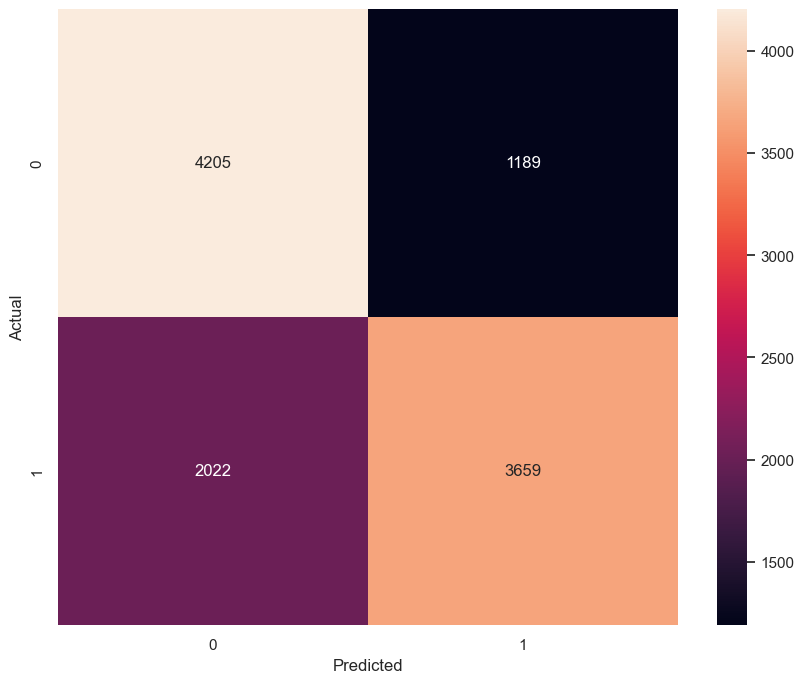

In [66]:
final_model = cbc_grid.best_estimator_
final_preds = final_model.predict(X_test)

cm = confusion_matrix(y_test, final_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Модель CatBoost хорошо показывает себя на тестовой выборке. Ошибается с положительными исходами чаще, чем с отрицательными.

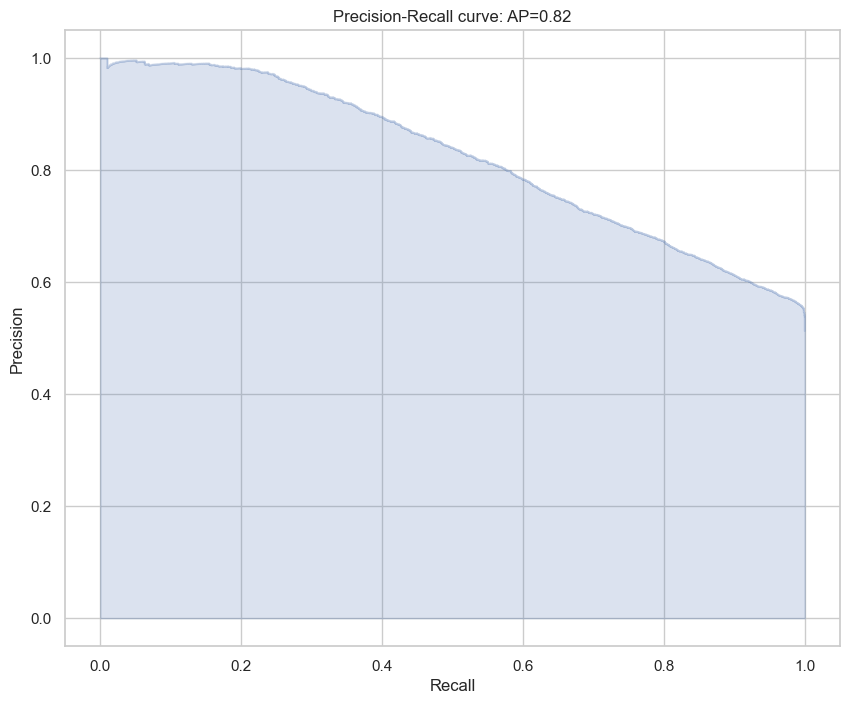

In [67]:
y_score = final_model.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_score)

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.figure(figsize=(10, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()


In [68]:
analysis_X_train = col_trans.fit_transform(X_train)
new_columns = num_cols + cat_cols
analysis_X_train = pd.DataFrame(analysis_X_train, columns=new_columns)


In [69]:
explainer = shap.Explainer(final_model['model'])

shap_values_1 = explainer(analysis_X_train)
shap_values_2 = shap.TreeExplainer(final_model['model']).shap_values(analysis_X_train)


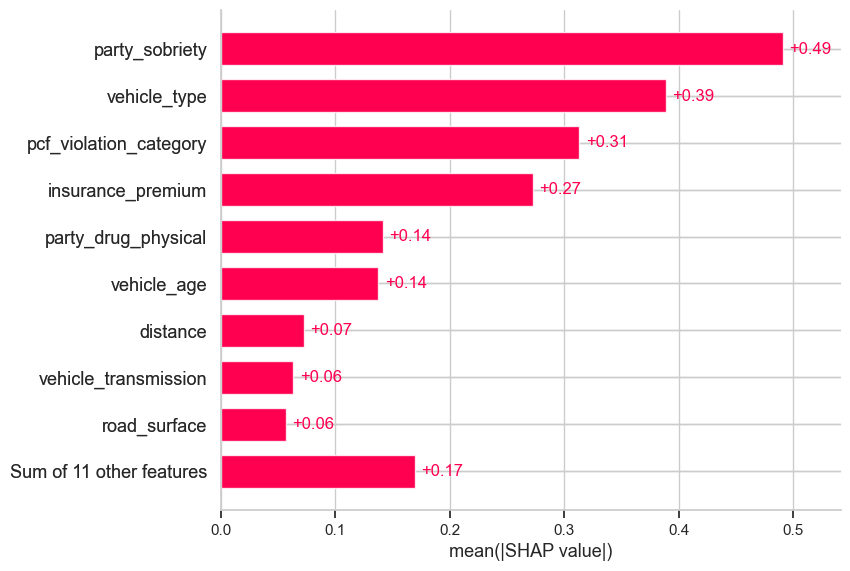

In [70]:
shap.plots.bar(shap_values_1)

Видим 4 основных фактора, которые влияют на исход аварии: party_sobriety, vehicle_type, pcf_violation_category, insurance_premium.
1. Трезвость участника
2. Тип авто
3. Категория нарушения
4. Сумма страховки (тыс. $)

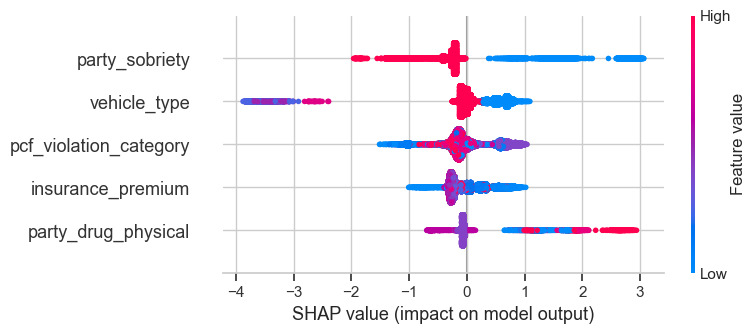

In [71]:
shap.summary_plot(shap_values_2, analysis_X_train, max_display=5, plot_size='auto')

### Выводы

Выявили, что основные факторы, влияющие на исход аварии, это влияние лекарственных средств на участника и трезвость участника. Также, важным фактором является сумма страховки и нарушения.

Предлагаю установить в автомобиль детектор алкоголя. Сделать обязательной проверку уровня алкоголя перед каждой поездкой. Для подтверждения, что тест проходит водитель, предусмотреть камеру, направленную на водительское место.

Также, можно установить ограничение скорости на транспортные средства, ввести штрафы за нарушения и предупреждения о нарушении.

## Выводы

In [72]:
acc = accuracy_score(y_test, final_preds)
rec = recall_score(y_test, final_preds)
f1 = 2 * (acc * rec) / (acc + rec)
print('Показатели лучшей модели на тестовой выборке:')
print('Accuracy:', acc)
print('Recall:', rec)
print('F1:', f1)

Показатели лучшей модели на тестовой выборке:
Accuracy: 0.7100677200902935
Recall: 0.6440767470515755
F1: 0.6754642779102699


Модель показывает неплохой результат, но его можно улучшить поработав более глубоко на предобработкой данных и подбором гиперпараметров.
Также, для улучшения показателей можно попробовать добавить следующие данные в датасет:
1. Данные о водителе
2. Данные о транспортном средстве
3. Исторические данные пользователя
4. Исторические данные транспортного средства
5. Количество перекрестков и других опасных мест на дороге